# Dataset Overview

In [1]:
import pandas as pd
df = pd.read_csv('public.csv')
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15565701,Ferri,698,Spain,Female,39,9,161993.89,1,0,0,90212.38,0
1,15565706,Akobundu,612,Spain,Male,35,1,0.00,1,1,1,83256.26,1
2,15565796,Docherty,745,Germany,Male,48,10,96048.55,1,1,0,74510.65,0
3,15565806,Toosey,532,France,Male,38,9,0.00,2,0,0,30583.95,0
4,15565878,Bates,631,Spain,Male,29,3,0.00,2,1,1,197963.46,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,15815628,Moysey,711,France,Female,37,8,113899.92,1,0,0,80215.20,0
7996,15815645,Akhtar,481,France,Male,37,8,152303.66,2,1,1,175082.20,0
7997,15815656,Hopkins,541,Germany,Female,39,9,100116.67,1,1,1,199808.10,1
7998,15815660,Mazzi,758,France,Female,34,1,154139.45,1,1,1,60728.89,0


# Use Pyspark to view dataset 

In [2]:
# These part is  for windows version, if you use ubuntu, remember to edit import pyspark part
# ----
# import findspark
# findspark.init()
# findspark.find()
# import pyspark
# findspark.find()
# ----
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn_Modelling").getOrCreate()
df = spark.read.csv('public.csv',header=True,inferSchema=True)
df.printSchema()

22/05/27 00:37:49 WARN Utils: Your hostname, Samuels-ROG-Flow-X13 resolves to a loopback address: 127.0.1.1; using 172.20.111.197 instead (on interface eth0)
22/05/27 00:37:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/27 00:37:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



# Do your work here

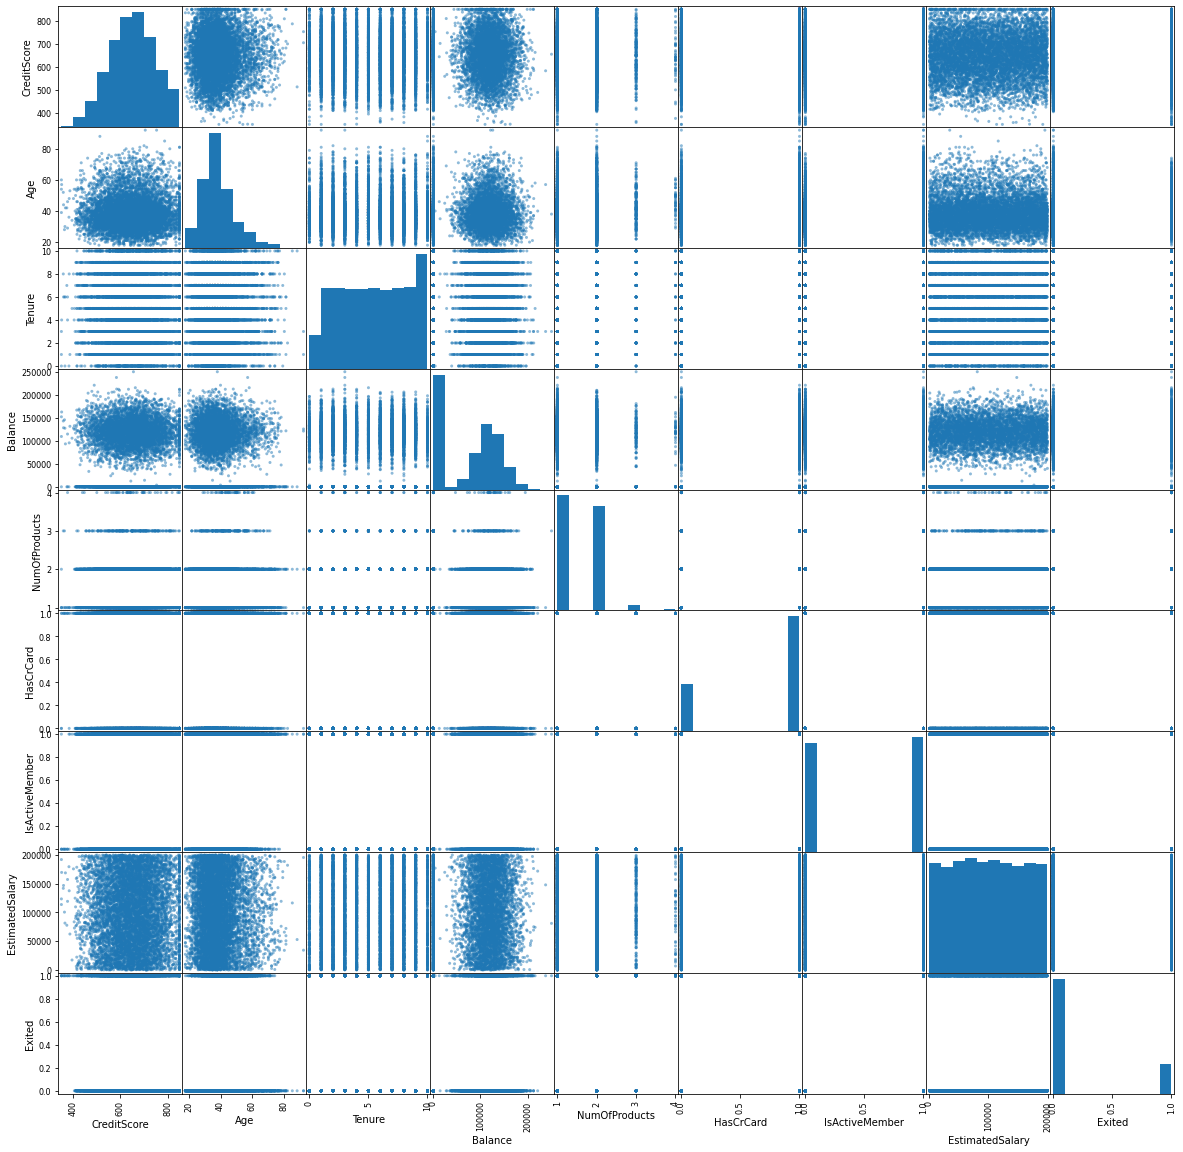

In [3]:
from pyspark.sql.functions import concat
from pandas.plotting import scatter_matrix


numeric_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Gender"]
label_title = "Exited"

numeric_features_df = df.select(*numeric_features, label_title)


# numeric_features_df.show()

axs = scatter_matrix(numeric_features_df.toPandas(), figsize=(20, 20))


In [4]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit, when, col


selected_features = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Gender"]
scale_features = ["CreditScore", "Age", "Tenure", "Balance", "EstimatedSalary"]


# selected_features = ["Age", "Balance", "NumOfProducts", "IsActiveMember", "EstimatedSalary"]
# scale_features = ["Age", "Balance", "EstimatedSalary"]

# selected_features = ["Age", "NumOfProducts", "IsActiveMember"]
# scale_features = ["Age"]


def preprocessData(df):
    features_df = df

    features_df = features_df.withColumn('Gender',
                                     when(col("Gender") == "Male", 1
                                          ).otherwise(0))

    unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())
    for i in scale_features:
        assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
        scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
        pipeline = Pipeline(stages=[assembler, scaler])
        features_df = pipeline.fit(features_df).transform(features_df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")


    for idx, feature_name in enumerate(selected_features):
        if(feature_name in scale_features):
            selected_features[idx]+="_Scaled"

    assembler = VectorAssembler(
        inputCols=selected_features,
        outputCol="features")

    features_df = assembler.transform(features_df)

    return features_df

In [5]:
features_df = preprocessData(df)
# features_df.show()
# features_df.select("features").show()

In [6]:
train_df, test_df = features_df.randomSplit([0.9, 0.1], seed = 0)
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 7179


Test Dataset Count: 821


In [7]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, MultilayerPerceptronClassifier, NaiveBayes

# classifier = LogisticRegression(featuresCol="features", labelCol=label_title, maxIter=500, aggregationDepth=20)
classifier = RandomForestClassifier(featuresCol="features", labelCol=label_title,
                                    maxDepth=25,
                                    numTrees=20,
                                    seed=0)
# classifier = LinearSVC(
#     featuresCol="features",
#     labelCol=label_title,
#     regParam=0.1,
#     maxIter=10
# )
# layers = [len(selected_features), 32, 32, 16, 2]
# classifier = MultilayerPerceptronClassifier(
#     labelCol=label_title,
#     featuresCol="features",
#     maxIter=300,
#     layers=layers,
#     blockSize=128,
#     seed=0)
# classifier = NaiveBayes(featuresCol="features", labelCol=label_title, smoothing=1.0, modelType="multinomial")

classifierModel = classifier.fit(train_df)

# classifierModel.featureImportances


22/05/27 00:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1305.4 KiB
22/05/27 00:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
22/05/27 00:38:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/05/27 00:38:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/05/27 00:38:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/05/27 00:38:27 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/05/27 00:38:28 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/05/27 00:38:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/05/27 00:38:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/05/27 00:38:30 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/05/27 00:38:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/05/27 00:38:31 WARN DAGScheduler: Broadcastin

| maxDepth | numTrees | Testing F1 Score |
| -------- | -------- | ---------------- |
| 20       | 40       | 0.59             |
| 20       | 30       | 0.60             |
| 20       | 20       | 0.61             |
| 20       | 10       | 0.54             |
| 30       | 20       | 0.615            |
| 25       | 20       | 0.615            |
| 20       | 20       | 0.613            |
| 15       | 20       | 0.61             |
| 10       | 20       | 0.61             |
| 5        | 20       | 0.58             |



In [8]:
import matplotlib.pyplot as plt
import numpy as np

# beta = np.sort(classifierModel.coefficients)
# plt.plot(beta)
# plt.ylabel('Beta Coefficients')
# plt.show()


In [9]:
# trainingSummary = classifierModel.summary
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'],roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [10]:
# pr = trainingSummary.pr.toPandas()
# plt.plot(pr['recall'],pr['precision'])
# plt.ylabel('Precision')
# plt.xlabel('Recall')
# plt.show()

In [11]:
predictions = classifierModel.transform(test_df)
predictions.select('Exited', 'rawPrediction', 'prediction').show(10)

22/05/27 00:38:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+------+--------------------+----------+
|Exited|       rawPrediction|prediction|
+------+--------------------+----------+
|     1|          [19.0,1.0]|       0.0|
|     0|[19.9069696969696...|       0.0|
|     0|[11.9444444444444...|       0.0|
|     0|[19.9398071762696...|       0.0|
|     0|[17.8317270079067...|       0.0|
|     0|[18.2036666666666...|       0.0|
|     0|[18.8461538461538...|       0.0|
|     0|[14.6838969686350...|       0.0|
|     0|[17.8317270079067...|       0.0|
|     1|[10.6589743589743...|       0.0|
+------+--------------------+----------+
only showing top 10 rows



In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol=label_title)
print('Test Area Under ROC', evaluator.evaluate(predictions))

22/05/27 00:38:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


Test Area Under ROC 0.8283224501057689


In [13]:
from sklearn import metrics
import numpy as np

truth_data_array = np.array(predictions.select('Exited').collect())
data_array =  np.array(predictions.select('prediction').collect())

print(data_array.sum(), data_array.max(), data_array.min())
print(truth_data_array.sum(), truth_data_array.max(), truth_data_array.min())


metrics.f1_score(truth_data_array, data_array)  

22/05/27 00:38:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


107.0 1.0 0.0
166 1 0


0.6153846153846153

# Public Evaluation Part

## Load private dataset, the same structure as public dataset

In [14]:
df_private_evl = spark.read.csv('public.csv',header=True,inferSchema=True)  # TA takes public dataset as example

## Do prediction with your PySpark model here (**Very Important**)
You must do prediction (inference) here.
Then TA will know how to run your ML model to test private data.

In [15]:
df_private_evl = spark.read.csv('public.csv', header=True, inferSchema=True)  # TA takes public dataset as example
df_private_truth = spark.read.csv('public.csv', header=True, inferSchema=True)  # TA takes public dataset as example

private_features_df = preprocessData(df_private_evl)
predictions = classifierModel.transform(private_features_df)

# predictions.show()
# predictions = predictions.withColumn('prediction',
#                                      when(col("CreditScore") < 400, 1
#                                           ).otherwise(col("prediction")))
# predictions = predictions.withColumn('prediction',
#                                      when(col("Age") > 75, 1
#                                           ).otherwise(col("prediction")))
# predictions = predictions.withColumn('prediction',
#                                      when(col("NumOfProducts") == 4, 1
#                                           ).otherwise(col("prediction")))

df_private_evl = predictions.select(predictions["CustomerId"], predictions["prediction"].alias(label_title))


## Print Your result as the following type

In [16]:
df_private_evl.select('CustomerId','Exited').show(5)

22/05/27 00:38:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


+----------+------+
|CustomerId|Exited|
+----------+------+
|  15565701|   0.0|
|  15565706|   1.0|
|  15565796|   0.0|
|  15565806|   0.0|
|  15565878|   0.0|
+----------+------+
only showing top 5 rows



## Calculate f-1 score

In [17]:
from sklearn import metrics
import numpy as np

truth_data_array = np.array(df_private_truth.select('Exited').collect())
data_array = np.array(df_private_evl.select('Exited').collect())

print(truth_data_array.sum(), truth_data_array.min(), truth_data_array.max())
print(data_array.sum(), data_array.min(), data_array.max())


metrics.f1_score(truth_data_array, data_array)


22/05/27 00:38:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


1644 0 1
1522.0 0.0 1.0


0.9425142135186356

# ------------------------------------------------------------------------------------------------------
## Private Evaluation Part (TA will use this block to test your model)
Please 

In [ ]:
df_private = spark.read.csv('private.csv',header=True,inferSchema=True)  # TA takes private dataset as example

## Do prediction with your PySpark model here

## TA will use the following function to get your prediction result (f-1 score)

In [ ]:
from sklearn import metrics
import numpy as np
data_array =  np.array(df_private.select('Exited').collect())

metrics.f1_score(data_array,data_array)  